## 5 - A journey
>Map any journey. Personal or not. Trace a journey—this could be a daily commute, a long-distance trip, or something from history. The key is to map movement from one place to another. 🚶\u200d♂️✈️

In [2]:
import cartopy.crs as ccrs
import geopandas as gpd
import osmnx as ox
from shapely import MultiPolygon
import shapely
import mapping_funcs as mf
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import rioxarray as rio
import seaborn as sns
import xarray as xr

# ox.settings.max_query_area_size = 6e12

## getting and exporting data

In [24]:
## get water features 
baltic_states = ox.geocode_to_gdf('Baltic States')
water = ox.features_from_polygon(baltic_states.geometry[0],
                                   tags={
                                       'natural':'water'
                                       }
                                   )

water_export = water.loc[water['water'].isin(['lake', 'reservoir', 'river', 'basin', 'oxbow', 'stream']),
                         ['name', 'geometry', 'water']].reset_index(drop=True)

water_export.to_parquet('baltic_states_water.parquet')

In [2]:
# get elevation data
aoi = shapely.from_wkt('POLYGON ((20.6009852 53.8967893, 28.2414937 53.8967893, 28.2414937 59.9383333, 20.6009852 59.9383333, 20.6009852 53.8967893))')
dem = mf.DEM.get_copernicus_dem(aoi, 90, rprj=False, interp=False)
dem.rename('dem').rio.to_raster('baltic_sates_dem.tiff')

## readng in routes, sampling elevation along route

In [6]:
## helper function for sampling along line
def sample_along_line(dem, ls, length, idx, date, crs, offset=0):

    n_samples = int(length*1000 / 90)
    point_xy = np.array(
        [ls.interpolate(i/n_samples,
                        normalized=True)
        .coords.xy for i in range(n_samples)]
        )[:,:,0]
    points = shapely.points(point_xy)
    cumulative = offset + np.asarray([(ls.project(p)/1000) for p in points])
    sample_gdf = (gpd.GeoDataFrame({'cumulative': cumulative,
                                    'date': date,
                                    'route_idx': idx,
                                    'color_idx': idx % 2,
                                    'x_utm': point_xy[:,0],
                                    'y_utm': point_xy[:, 1],
                                    },
                                index=cumulative,
                                geometry=points,
                                crs=crs)
                .rename_axis('cumulative')
                .sort_index()
                .to_crs(4326))
    sample_gdf['lon'] = sample_gdf['geometry'].apply(lambda p: p.x)
    sample_gdf['lat'] = sample_gdf['geometry'].apply(lambda p: p.y)
    
    sampled = dem.interp(x=sample_gdf['lon'].to_xarray(),
                         y=sample_gdf['lat'].to_xarray())

    sample_gdf['z'] = sampled.to_pandas()
    
    return sample_gdf

In [8]:
dem = rio.open_rasterio('baltic_sates_dem_clipped.tiff').squeeze()

route = gpd.read_file('tidy_routev3.geojson', columns=['bike','date','number','geometry'])
route = (route[route['bike']]
         .sort_values(by=['date',
                          'number'])
         .reset_index(drop=True))

utm_crs = route.estimate_utm_crs()
route = route.to_crs(utm_crs)
route['distance'] = route.length/1000
route['cumulative'] = route['distance'].cumsum()


samples = []
offset=0
for row in route.itertuples():
    sample = sample_along_line(dem,
                               row.geometry,
                               row.distance,
                               row.number,
                               row.date,
                               utm_crs,
                               offset)
    offset = row.cumulative
    samples.append(sample)


C:\Users\s1759665\AppData\Roaming\Python\Python312\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
C:\Users\s1759665\AppData\Roaming\Python\Python312\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


229


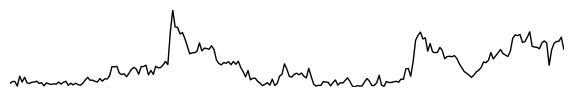

In [10]:
point_gdf = pd.concat(samples)

# resample to every 
sample_freq = 10  # units: km
resample_distances = np.arange(0, point_gdf['cumulative'].max(), sample_freq)
print(len(resample_distances))

resampled = point_gdf[['z']].reindex(
    point_gdf.index.union(resample_distances)
    ).interpolate('values').loc[resample_distances]

fig, ax = plt.subplots(figsize=[7.145, 1])
resampled.plot(c='k',
               linewidth=1,
               legend=False,
               ax=ax,
               )

ax.fill_between(resampled.index,
                resampled['z'],
                np.zeros_like(resampled['z']),
                color='w')

xlims = [0, resampled.index.max()]
ylims = [0, resampled['z'].max()]


ax.set(xlim=xlims,
       ylim=ylims,
       xticks=[],
       yticks=[],
       xlabel=None)

ax.set_axis_off()

# fig.savefig('baltic_profile.svg', transparent=True, bbox_inches='tight', pad_inches=0)